In [34]:
%load_ext autoreload
%autoreload 2

In [12]:
import pytorch_eo

pytorch_eo.__version__

'2024.05.03'

## Plot image

(544, 544)


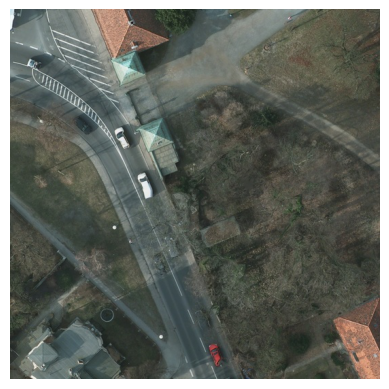

In [9]:

from PIL import Image
import matplotlib.pyplot as plt

# Open an image file
img = Image.open('/fastdata/COWC/v1/datasets/ground_truth_sets/result/test/images/slice_top_potsdam_2_14_RGB_1467_489_544_544_0.jpg')
print(img.size)
# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off axis labels
plt.show()

## Split the Ground-Truth-Data (GTD) into images and annotation bounding boxes 
### Requirements: 1. Location specific GTD must be moved into a data folder split into test and train folders (/data/test, data/train)
###               2. Output path for annotated files must be provided

In [1]:
from pytorch_eo.datasets.cowc.cowc import Cowc_annot
from pytorch_eo.datasets.cowc.cowc import ObjectDetectionDataModule
import pytorch_lightning as pl

# requires all contens from different ground truth sample location to be put inside data folder
# Structure: data --> train, test --> top_potsdam_6_8_RGB_Annotated_Cars.png, top_potsdam_6_8_RGB_Annotated_Negatives.png, top_potsdam_6_8_RGB_Annotated.xcf
cowc_processor = Cowc_annot()
cowc_processor.process('/fastdata/COWC/v1/datasets/ground_truth_sets/data', '/fastdata/COWC/v1/datasets/ground_truth_sets/processed')


### Use setup function to convert the data into VOC format

In [3]:
from torchvision.transforms import ToTensor
from pytorch_eo.datasets.cowc.cowc import ObjectDetectionDataModule

data_module = ObjectDetectionDataModule(data_dir='/fastdata/COWC/v1/datasets/ground_truth_sets/processed/', batch_size=4)

data_module.setup()

## Plot images and bounding boxes

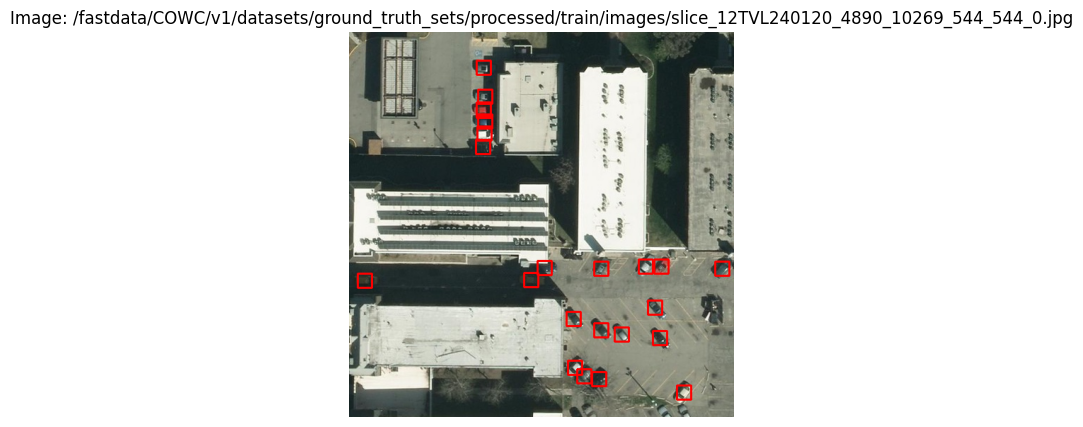

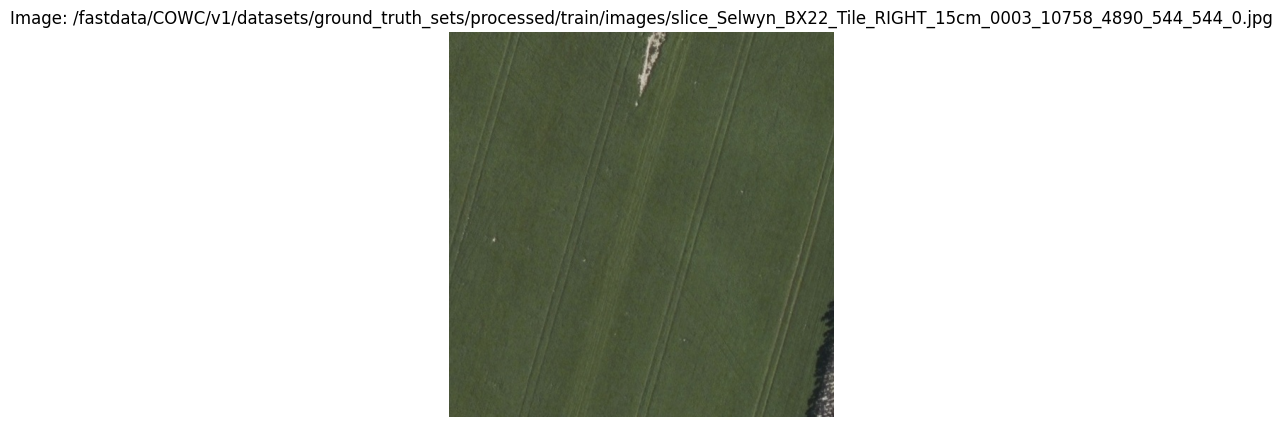

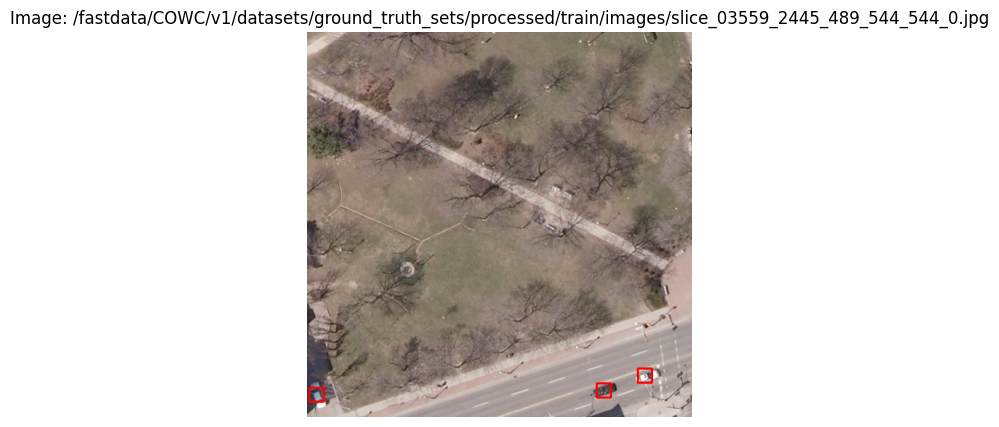

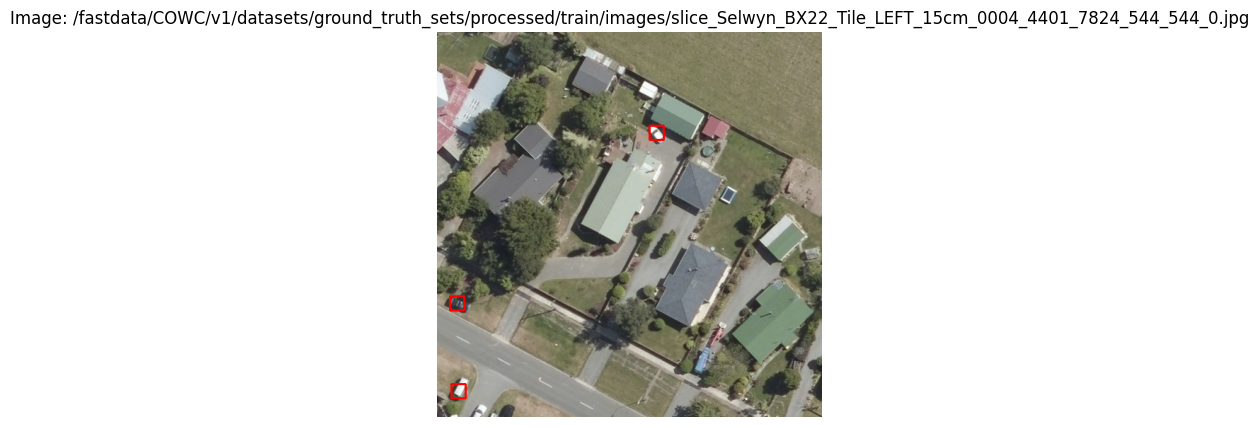

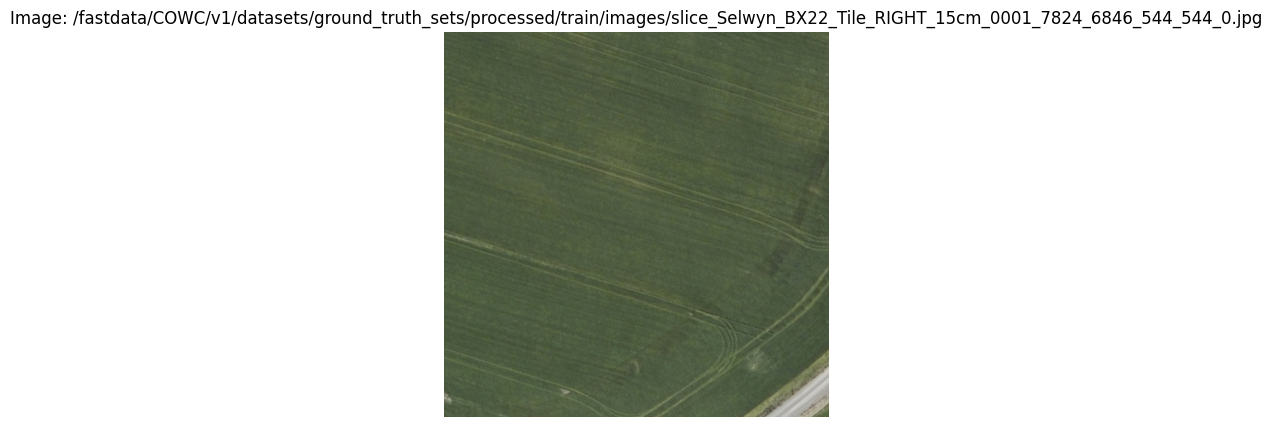

In [10]:
import cv2
import matplotlib as plt 
import numpy as np
from matplotlib import pyplot as plt

# Iterate over each image data
imgs = data_module.train_dataset.images[10:15]

for data in imgs:
    # Load the image
    img = cv2.imread(data['file_name'])
    
    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {data['file_name']}")
        continue
    
    # Draw each bounding box on the image
    for box in data['boxes']:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color with thickness 2
    
    # Convert BGR image (OpenCV format) to RGB image (matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Image: {data['file_name']}")
    plt.axis('off')  # Hide the axis
    plt.show()

## Initialize pretrained SSD model

In [4]:
import random
import torch
def worker_init_fn(worker_id):
    worker_info = torch.utils.data.get_worker_info()
    worker_info.seed = torch.initial_seed() % 2**32
    np.random.seed(worker_info.seed)
    random.seed(worker_info.seed)


In [2]:
import torchvision

model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
num_classes = 2  # 1 class (car) + background
model.head.classification_head.num_classes = num_classes


/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [47]:
import torchvision

from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils
from torchvision.models.detection import SSD300_VGG16_Weights

def create_model(num_classes=91, size=300):
    # Load the Torchvision pretrained model.
    model_new = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1
    )
    # Retrieve the list of input channels. 
    in_channels = _utils.retrieve_out_channels(model_new.backbone, (size, size))
    # List containing number of anchors based on aspect ratios.
    num_anchors = model_new.anchor_generator.num_anchors_per_location()
    # The classification head.
    model_new.head.classification_head = SSDClassificationHead(
        in_channels=in_channels,
        num_anchors=num_anchors,
        num_classes=num_classes,
    )
    # Image size for transforms.
    model_new.transform.min_size = (size,)
    model_new.transform.max_size = size
    return model_new

model_new = create_model(2, 544)

### Start model training

In [60]:
import torch
import torch.optim as optim
from torchvision.models.detection import ssd300_vgg16
from torchvision.models.detection import SSD300_VGG16_Weights

device = torch.device('cuda') #if torch.cuda.is_available() else torch.device('cpu')
model_new = model_new = torchvision.models.detection.ssd300_vgg16(
        weights=SSD300_VGG16_Weights.COCO_V1)
model_new.transform.min_size = (544,)
model_new.transform.max_size = 544
model_new.to(device)

val_torch = data_module.val_dataloader()
train_torch = data_module.train_dataloader()

params = [p for p in model_new.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

num_epochs = 10

for epoch in range(num_epochs):
    model_new.train()
    train_loss = 0
    for images, targets in train_torch:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        losses = model_new(images, targets)
        loss = sum(loss for loss in losses.values())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    print(f"Epoch: {epoch}, Loss: {train_loss/len(train_torch)}")

    model_new.eval()
    valid_loss = 0
    with torch.no_grad():
        for images, targets in val_torch:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            predictions = model_new(images)

# Save the Model
torch.save(model_new.state_dict(), 'ssd_model_new.pth')


In [17]:
import torch
import torch.optim as optim
from torchvision.models.detection import ssd300_vgg16
from torch.utils.tensorboard import SummaryWriter
import numpy as np

device = torch.device('cuda') # if torch.cuda.is_available() else torch.device('cpu')

model = ssd300_vgg16(pretrained=True)
num_classes = 2  # 1 class (car) + background
model.head.classification_head.num_classes = num_classes
model.to(device)

val_torch = data_module.val_dataloader()
train_torch = data_module.train_dataloader()

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

writer = SummaryWriter()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, targets in train_torch:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        losses = model(images, targets)
        loss = sum(loss for loss in losses.values())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    train_loss /= len(train_torch)
    writer.add_scalar('Loss/train', train_loss, epoch)
    print(f"Epoch: {epoch}, Train Loss: {train_loss}")

    model.eval()
    with torch.no_grad():
        for images, targets in val_torch:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            optimizer.zero_grad()
            preds = model(images)

    lr_scheduler.step()

# Save the Model
torch.save(model.state_dict(), 'ssd_model_improved.pth')

writer.close()


/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Train Loss: 2.2152454729409365
Epoch: 1, Train Loss: 1.7653719442662146
Epoch: 2, Train Loss: 1.6954566567749128
Epoch: 3, Train Loss: 1.5911410852304777
Epoch: 4, Train Loss: 1.548043913652996
Epoch: 5, Train Loss: 1.5607539241341286
Epoch: 6, Train Loss: 1.5145235956823468
Epoch: 7, Train Loss: 1.5256313168952336
Epoch: 8, Train Loss: 1.524989704672975
Epoch: 9, Train Loss: 1.5087617380402056


### Export model to ONNX

In [19]:
model.to(device)

# Define example inputs
dummy_input = torch.randn(1, 3, 300, 300).to(device)  # Example input tensor of correct shape

# Export to ONNX
torch.onnx.export(model,                     # Model being run
                  dummy_input,               # Example input
                  "ssd_model_improved.onnx",          # Path to save the ONNX model
                  export_params=True,        # Store the trained parameter weights inside the model file
                  opset_version=11,          # the ONNX version to export the model to
                  do_constant_folding=True,  # Whether to execute constant folding for optimization
                  input_names = ['input'],   # Input names within the model
                  output_names = ['output'], # Output names within the model
                  dynamic_axes={'input' : {0 : 'batch_size'},    # Variable length axes
                                'output' : {0 : 'batch_size'}})

print('ONNX export success, saved as ssd_model.onnx')

/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/ops/boxes.py:157: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_x = torch.min(boxes_x, torch.tensor(width, dtype=boxes.dtype, device=boxes.device))
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/ops/boxes.py:159: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  boxes_y = torch.min(boxes_y, torch.tensor(height, dtype=boxes.dtype, device=boxes.device))
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/detection/transform.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX export success, saved as ssd_model.onnx


## Load saved model and test performance

In [5]:
import torch
import torch.optim as optim
from torchvision.models.detection import ssd300_vgg16
# 2. Load the saved state dictionary

model = ssd300_vgg16(pretrained=True)
num_classes = 2  # 1 class (car) + background
model.head.classification_head.num_classes = num_classes

checkpoint = torch.load('ssd_model_improved.pth', map_location=torch.device('cpu'))  # Load on CPU, change if loading on GPU

model.load_state_dict(checkpoint)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/anna/miniconda3/envs/pytorchEO/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

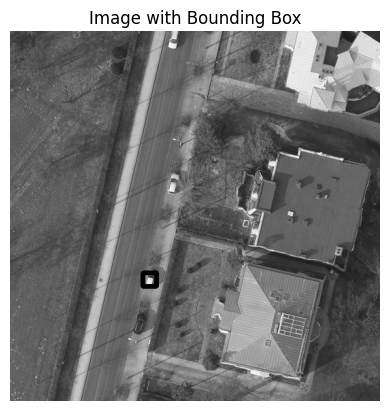

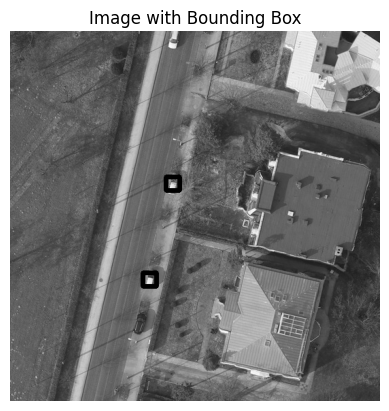

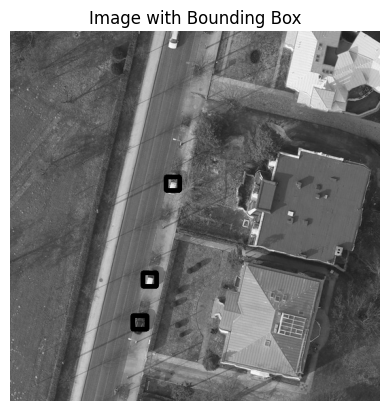

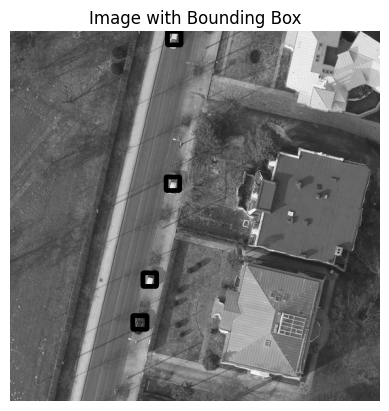

tensor(0.2951, device='cuda:0')
tensor(0.2761, device='cuda:0')
tensor(0.2201, device='cuda:0')
tensor(0.1915, device='cuda:0')


In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from torchvision import transforms as T

val_torch = data_module.val_dataloader()
train_torch = data_module.train_dataloader()

with torch.no_grad():
        for images, targets in val_torch:
            images = list(image.to(device) for image in images)

# Load the image using PIL (or any other image loading library)
img = images[0][1].cpu().numpy()

# Convert image tensor to numpy array for plotting (if necessary)
#img = images[i].cpu().numpy()

with torch.no_grad():
    model.eval()
    predictions = model(images)
    bbox, scores, labels = predictions[0]['boxes'], predictions[0]['scores'], predictions[0]['labels']
    bbox.cpu()
    scores.cpu()
    labels.cpu()
    nums = torch.argwhere(scores > 0.19).shape[0]
    for i in range(nums):
        x,y,w,h = bbox[i].cpu().numpy().astype('int')
        cv2.rectangle(img, (x,y), (w,h), (0,0,255),5)


        # Use matplotlib to display the image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Image with Bounding Box')
        plt.axis('off')  # Hide axes
        plt.show()

for i in range(0, 4):     
    print(predictions[0]['scores'][i])

(544, 544, 3)


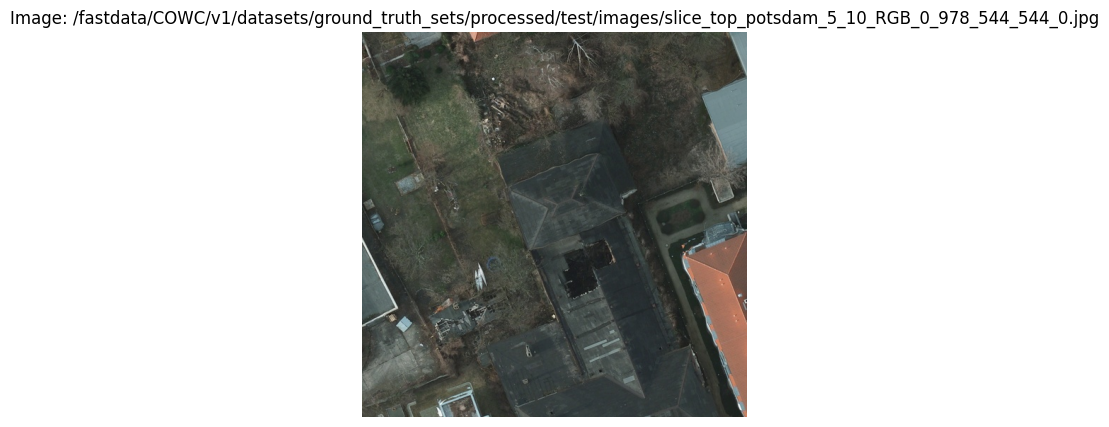

(544, 544, 3)


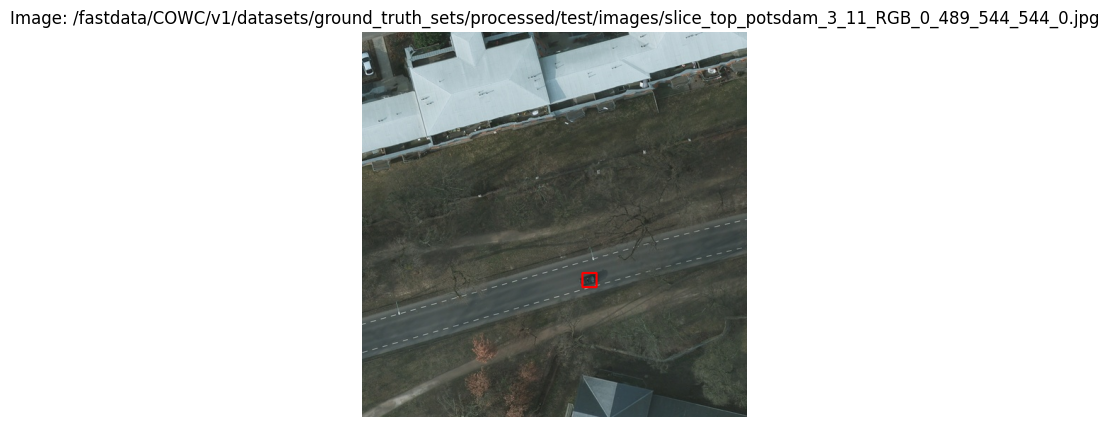

(544, 544, 3)


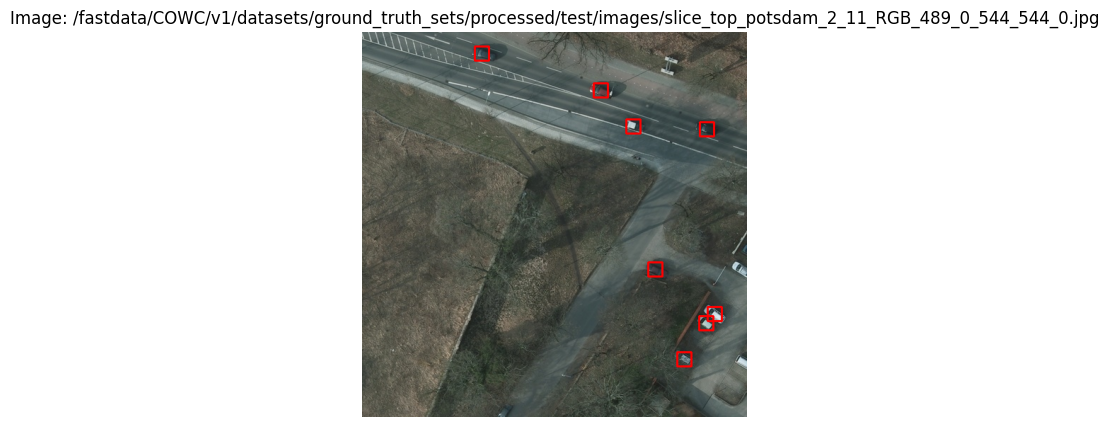

(544, 544, 3)


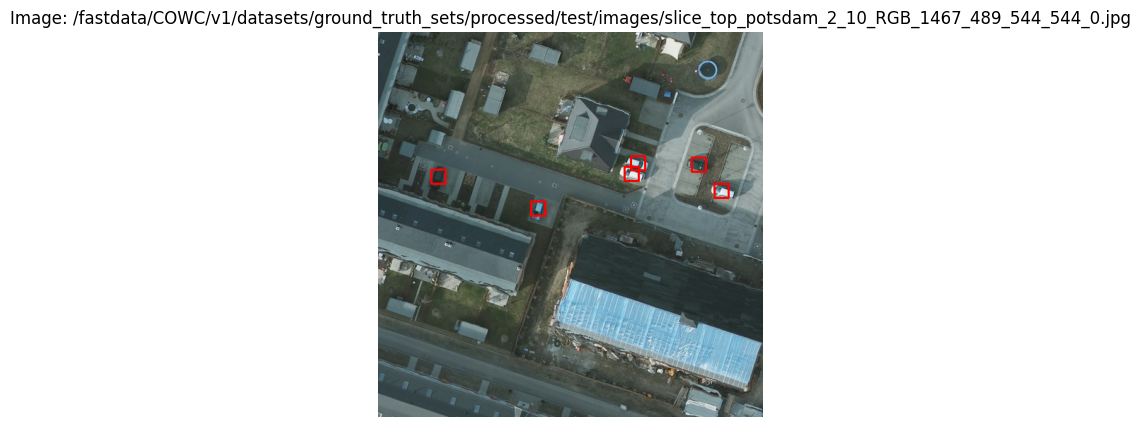

(544, 544, 3)


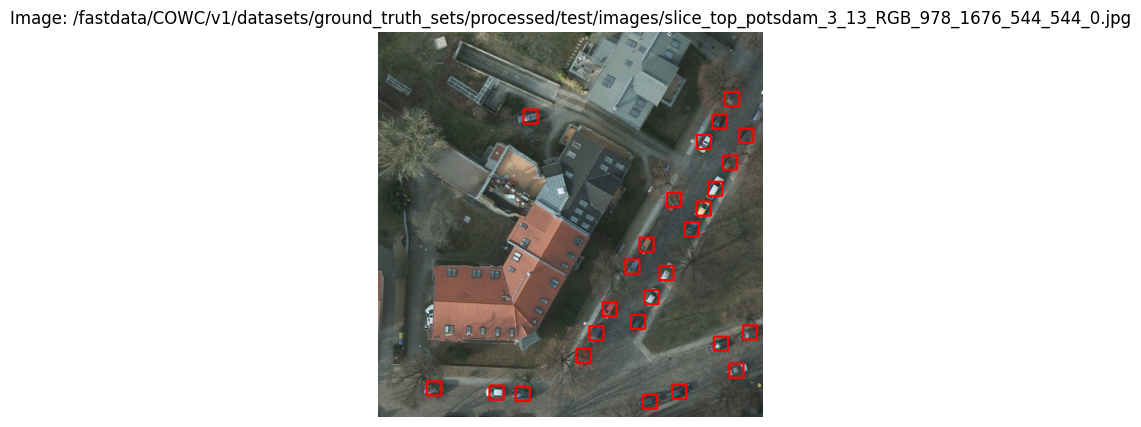

In [59]:
# Iterate over each image data
imgs = data_module.val_dataset.images[0:5]


for data in imgs:
    # Load the image
    img = cv2.imread(data['file_name'])
    print(img.shape)
    
    # Check if the image was loaded successfully
    if img is None:
        print(f"Error loading image: {data['file_name']}")
        continue
    
    # Draw each bounding box on the image
    for box in data['boxes']:
        x1, y1, x2, y2 = box
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Red color with thickness 2
    
    # Convert BGR image (OpenCV format) to RGB image (matplotlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(5, 5))
    plt.imshow(img_rgb)
    plt.title(f"Image: {data['file_name']}")
    plt.axis('off')  # Hide the axis
    plt.show()